# SI: Binding of Pyrophopshate and Citrate to Lysozyme and Their Role in Charge Reversal
_Stefan Hervø-Hansen, Coralie Pasquier, Jordan Bye, Robin Curtis, and Mikael Lund, 2017_

This Jupyter Notebook serves the purpose of investigating the assumption of a native-like structure of lysozyme in the pressence of pyrophosphate(-4*e*). This assumption is utilized for the Monte Carlo simulations in the investigation of lysozyme undergoing aggregation in the pressence of modderate concentrations of pyrophosphate, while at high concentrations of pyrophosphate, lysozyme experences charge reversal causing a releif in aggregation.

All simulations have been performed using the Amber molecular dynamics software, with all settings customizable and visual in this notebook. For instructions on the meaning of the various parameters specificed in this notebook please consult the Amber manual, which can be found [here](http://ambermd.org/doc12/Amber17.pdf).

## Software Requirements
1. AmberTools17/Amber16<sup>†</sup>
2. Packmol<sup>†</sup>
3. Python3
    1. `matplotlib`
    2. `pytraj`
    3. `numpy`

†: Required if `do_simulation = True` (see below).
## Python Module Imports and Directories

In [1]:
import os
import datetime
import pytraj as pt
import matplotlib.pyplot as plt
from IPython.display import Markdown
import nglview as nv

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
parent = '/temp1/stefan/md_salt_lysozym/'
workdir_POP = '/temp1/stefan/md_salt_lysozym/Pyrophosphate/'
home_dir    = '/home/mikael/stefan/md_salt_lysozym/'
print('Directories:')
print('parent: {}'.format(parent))
print('workdir_POP: {}'.format(workdir_POP))
print('home_dir: {}\n'.format(home_dir))
%cd -q $parent
cdir = %pwd
print('Current directory: {}\n'.format(cdir))
dt = datetime.datetime.now()
print('Current run started: {:{dfmt} {tfmt}}'.format(dt, dfmt='%Y-%m-%d', tfmt='%H:%M'))

Directories:
parent: /temp1/stefan/md_salt_lysozym/
workdir_POP: /temp1/stefan/md_salt_lysozym/Pyrophosphate/
home_dir: /home/mikael/stefan/md_salt_lysozym/

Current directory: /temp1/stefan/md_salt_lysozym

Current run started: 2017-12-23 19:53


## _ATTENTION_: Simulation Overwrite
With this notebook comes a set of pre-runned simulations found in the `Pyrophosphate` directory. If `do_simulation = True` the pre-runned simulations will be overwritten by default, while if `do_simulation = False` the analysis will be performed on the pre-runned simulations.

In [2]:
do_simulation = False  # Recommended

## Asignment of Force Field Parameters and Preparation of Initial Structure
The asignment of force field parameters to pyrophosphate and citrate has been performed by fitting restrained electrostatic potential (RESP) partial atomic charges using HF/6-31G\* to the B3LYP/6-31G\* optimized geometry of the ligand using Gaussian09 and antechamber with force field parameters asigned from the generalized amber force field version 2 (GAFF2). Lysozyme and the ligand was initially packed with Packmol and later solvated in explicit TIP3P water using LeAP.

All atomic partial charges of ionic groups including sodium, pyrophosphate, and chloride were scaled by $\frac{1}{\sqrt{\epsilon_{\mathrm{el}}}}$ in order to effectively set a dielectic constant of 1.78. See Appendix for deviation.

Several structure and parameter files are readily available:
- <font color='#660066'> 1hel_fixed.pqr </font>: all atomic structure file for lysozyme.
- <font color='#660066'> CHL.pdb </font>: all atomic structure file for the chloride atom.
- <font color='#660066'> SOD.pdb </font>: all atomic structure file for the sodium atom.
- <font color='#660066'> POP.pdb </font>: all atomic structure file for the pyrophosphate molecule.
- <font color='#660066'> SOD.mol2 </font>: parameter file for charged scaled sodium.
- <font color='#660066'> CHL.mol2 </font>: parameter file for charged scaled chloride.
- <font color='#660066'> POP_scaled.mol2 </font>: parameter file for charge scaled pyrophosphate.
- <font color='#660066'> frcmod.tip3p_ion_scaled </font>: parameter file containing non-bonded Lennard-Jones parameters for charged scaled sodium and chloride.

### Tetrasodium pyrophosphate

In [3]:
%%bash -s "$do_simulation" "$parent" "$workdir_POP" "$home_dir"
export AMBERHOME=/temp1/Software/amber16
source /temp1/Software/amber16/amber.sh

if [ "$1" = "True" ]; then

cd $2
if [ ! -d "Pyrophosphate" ]; then
  mkdir Pyrophosphate
fi
cd $3
if [ ! -d "POP_parameter" ]; then
  mkdir POP_parameter
fi
cd POP_parameter

cp $4/Struc_parm/POP_scaled.mol2 .
cp $4/Struc_parm/CHL.mol2 .
cp $4/Struc_parm/SOD.mol2 .
cp $4/Struc_parm/CHL.pdb .
cp $4/Struc_parm/SOD.pdb .
cp $4/Struc_parm/POP.pdb .
cp $4/Struc_parm/1hel_fixed.pqr .
cp $4/Struc_parm/frcmod.tip3p_ion_scaled .

# Initial packing
cat <<EOF > pack_HEWL_POP.in
tolerance 2.0
filetype pdb
output HEWL_POP.pdb

structure 1hel_fixed.pqr       # Lysozym
        number 1
        fixed 0. 0. 0. 0. 0. 0.
        centerofmass
end structure

structure CHL.pdb              # Chloride
        number 11              # Vary this number to neutralize
        inside sphere 0. 0. 0. 50.
end structure

structure POP.pdb              # Tetravalent pyrophosphate
        number 150
        inside sphere 0. 0. 0. 50.
end structure

structure SOD.pdb              # Sodium
        number 600
        inside sphere 0. 0. 0. 50.
end structure
EOF
~/packmol-17.163/packmol < pack_HEWL_POP.in

# Amber Input file generation
cat <<EOF > tleap.in
source leaprc.protein.ff14SB
source leaprc.gaff2
source leaprc.water.tip3p

loadAmberParams frcmod.tip3p_ion_scaled

POP = loadmol2 POP_scaled.mol2
SOD = loadmol2 SOD.mol2
CHL = loadmol2 CHL.mol2
Lyso = loadpdb HEWL_POP.pdb

solvateOct  Lyso TIP3PBOX 10.0

saveAmberParm Lyso HEWL_POP.parm7 HEWL_POP.rst7
charge Lyso
quit
EOF

tleap -f tleap.in

# Cp files to workdir_POP
cp HEWL_POP.parm7 HEWL_POP.rst7 $3
printf "System ready!"

else
printf "Using pre-runned simulation.\nSystem ready!"
fi

Using pre-runned simulation.
System ready!

## Molecular dynamics
The framework of Amber16/AmberTools17 with the *pmemd* program is used to perform all atomic molecular dynamics.
Performed on GPUs (originally on 1 Tesla 80K) using the Cuda platform.

Preliminary molecular dynamics runs and their associated output data are saved in the their reseptive workdir with the tags `min`, `heat`, and `equil` to distinguish the initial phases while production run is saved in a seperate folder in the workdir with the tag `prod`. The input and output files of the simulations are:
- <font color='#0000cc'> *.rst7 </font>: AMBER restart file. Compatible with VMD.
- <font color='#0000cc'> *.parm7 </font>: AMBER topology file. Compatible with VMD.
- <font color='#0000cc'> *.mdin </font>: AMBER input file.
- <font color='#0000cc'> *.mdout </font>: AMBER output file. Readable state info and diagnostics.
- <font color='#0000cc'> *.nc </font>: AMBER trajectory file. NetCDF trajectory compatible with VMD with topology file.
- <font color='#0000cc'> mdinfo </font>: Simulation information for the most recent written frame. Overwritten by all simulations.



### Minimization
Minimization performed over a maximum of 10000 steps with the first 1000 steps using steepest decent switching over to conjugated gradient. The minimization was performed with harmonic C$_{\alpha}$ restraints using a force constant of 20 $\frac{\mathrm{kcal ~Å}^{2}}{\mathrm{mol}}$ according to Hooke's law.

In [4]:
# Workdirectory for minimization, heating and equilibration.
%cd -q $workdir_POP

In [5]:
%%bash -s "$do_simulation"
if [ "$1" = "True" ]; then

export CUDA_HOME=/usr/local/cuda
export AMBERHOME=/temp1/Software/amber16
source /temp1/Software/amber16/amber.sh

# Minimization:
cat <<EOF > min.mdin
Minimization
&cntrl
   imin = 1,                   ! Turn on minimization
   ncyc = 1000,
   maxcyc = 10000,             ! Total number of minimization cycles
   ntpr = 50,
   cut = 8,
   ntr = 1,                    ! Turn on positional restraints
   restraint_wt = 10.0,        ! 10 kcal/mol/A**2 restraint force constant
   restraintmask = '!:WAT&@CA' ! Restraints on Ca atoms only.
/
EOF

cp 

pmemd.cuda -O -i min.mdin -p HEWL_POP.parm7 -c HEWL_POP.rst7 -o HEWL_POP.min.mdout -r HEWL_POP.min.rst7 -ref HEWL_POP.rst7
printf "Minimization done!\n"

else
printf "Using pre-runned simulation.\nMinimization Done!"
fi

Using pre-runned simulation.
Minimization Done!

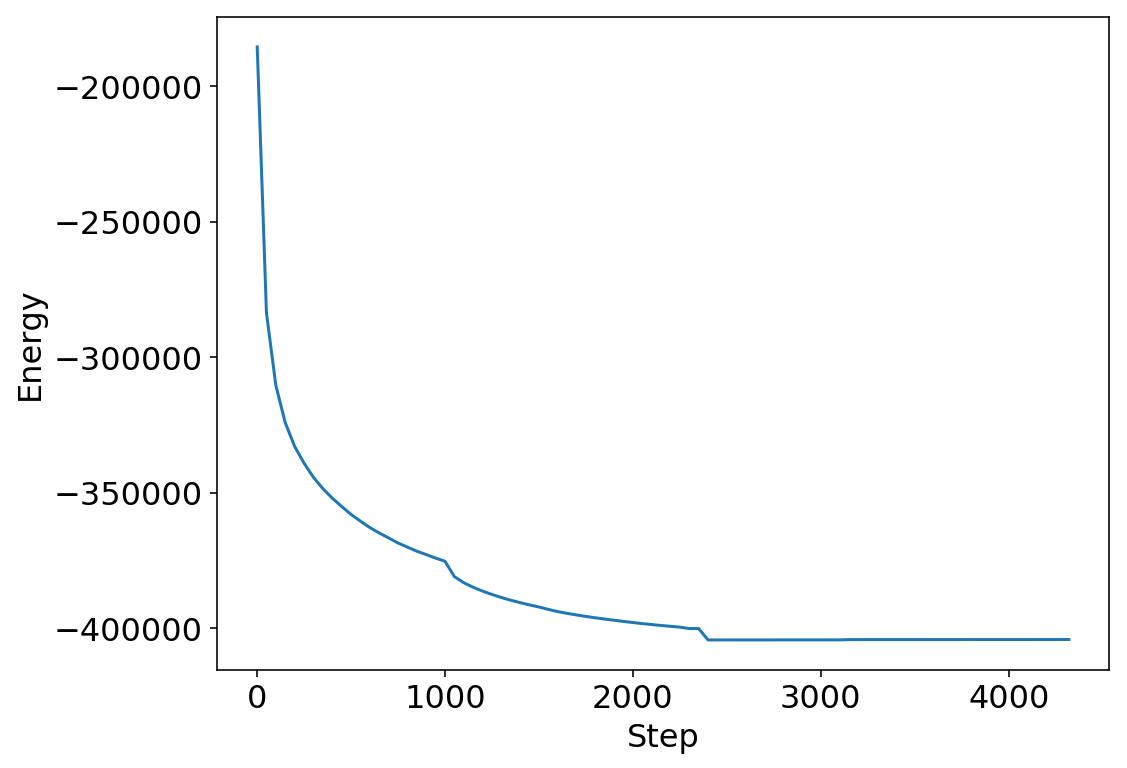

In [6]:
Etot = []        # Total potential energy.
step = []        # Step number.
token = False
f = open("HEWL_POP.min.mdout")
for line in f:
    fields = line.strip().split()
    if len(fields) > 1:
        if fields[0] == "NSTEP" and fields[1] == "ENERGY":
            token = True
        elif token == True:
            step.append(fields[0])
            Etot.append(fields[1])
            token = False

plt.plot(step, Etot)
plt.xlabel("Step")
plt.ylabel("Energy")

### Heating
Linear gradiant in temperature using Langevin dynamics starting from 10 K to 300K over 0.3 ns with additional 0.1 ns of MD at 300K at constant volume.

In [7]:
%%bash -s "$do_simulation"
if [ "$1" = "True" ]; then

export CUDA_HOME=/usr/local/cuda
export AMBERHOME=/temp1/Software/amber16
source /temp1/Software/amber16/amber.sh

cat <<EOF > heat.mdin
Explicit solvent initial heating mdin
 &cntrl
   imin=0, irest=0, ntx=1,
   ntpr=1000, ntwx=1000, nstlim=200000,
   dt=0.002, ntt=3, gamma_ln=5.0, ig=-1,
   ntc=2, ntf=2, cut=8, ntb=1,
   iwrap=1, ioutfm=1, nmropt=1,
 /
 &wt
   TYPE='TEMP0', ISTEP1=0, ISTEP2=150000,
   VALUE1=10.0, VALUE2=300.0,
 /
 &wt TYPE='END' /
EOF

pmemd.cuda -O -i heat.mdin -p HEWL_POP.parm7 -c HEWL_POP.rst7 -o HEWL_POP.heat.mdout -r HEWL_POP.heat.rst7
printf "Heating done!\n"

else
printf "Using pre-runned simulation.\nHeating done!"
fi

Using pre-runned simulation.
Heating done!

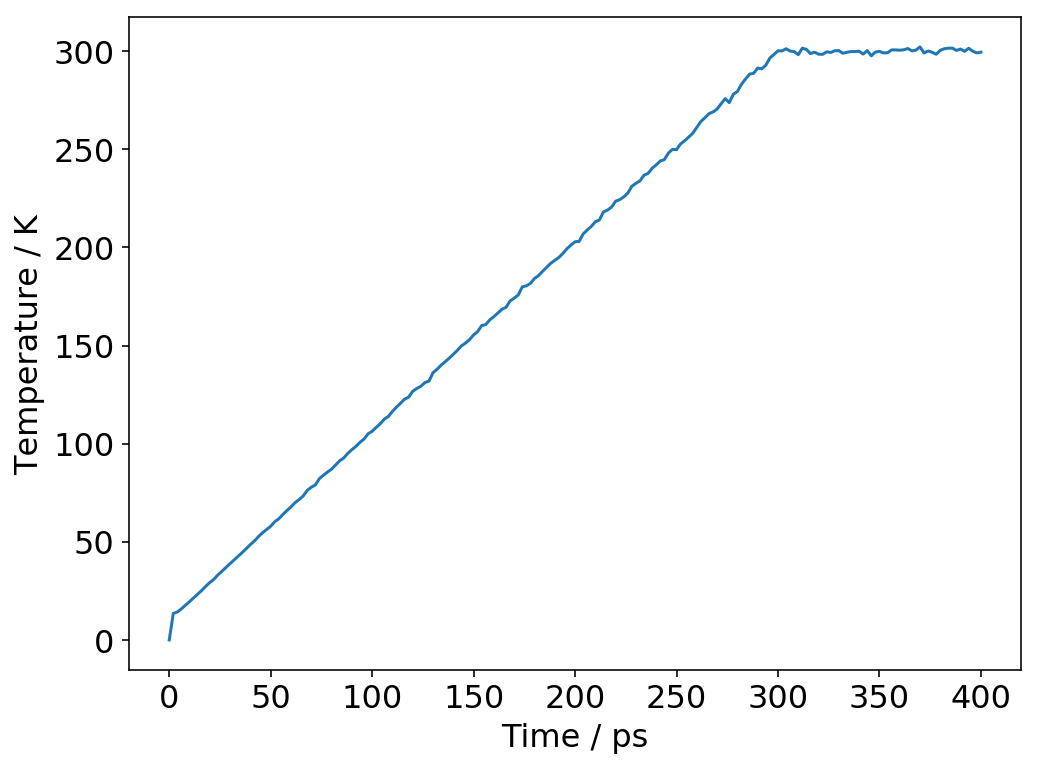

In [8]:
temp = []        # Temperature in Kelvin.
time = []        # Time in picoseconds.        
f = open("HEWL_POP.heat.mdout")
for line in f:
    fields = line.strip().split()
    if len(fields) > 6: 
        if fields[3] == "TIME(PS)" and fields[6] == "TEMP(K)":
            time.append(fields[5])
            temp.append(fields[8])


plt.plot(time[:-2], temp[:-2])        # Remove last two entries (not data points)
plt.xlabel("Time / ps")
plt.ylabel("Temperature / K")

### Equilibration (Relaxation)
1 ns relaxation in *NPT* ensemble at 1 bar pressure using a Monte Carlo barostat, sampling from the isobaric-isothermal ensemble, with a reference pressure of 1 bar and 300 K using Langevin dynamics.

In [9]:
%%bash -s "$do_simulation"
if [ "$1" = "True" ]; then

export CUDA_HOME=/usr/local/cuda
export AMBERHOME=/temp1/Software/amber16
source /temp1/Software/amber16/amber.sh

cat <<EOF > equil.mdin
Explicit solvent molecular dynamics
 &cntrl
   imin=0, irest=1, ntx=5,
   ntpr=1000, ntwx=1000, nstlim=500000,
   dt=0.002, ntt=3, tempi=300,
   temp0=300, gamma_ln=1.0, ig=-1,
   ntp=1, ntc=2, ntf=2, cut=8,
   ntb=2, iwrap=1, ioutfm=1,
   barostat=2, pres0=1.0,
 /
EOF

pmemd.cuda -O -i equil.mdin -p HEWL_POP.parm7 -c HEWL_POP.heat.rst7 -o HEWL_POP.equil.mdout -r HEWL_POP.equil.rst7 -x HEWL_POP.equil.nc
printf "Equilibration done!\n"

else
printf "Using pre-runned simulation.\nEquilibration done!"
fi

Using pre-runned simulation.
Equilibration done!

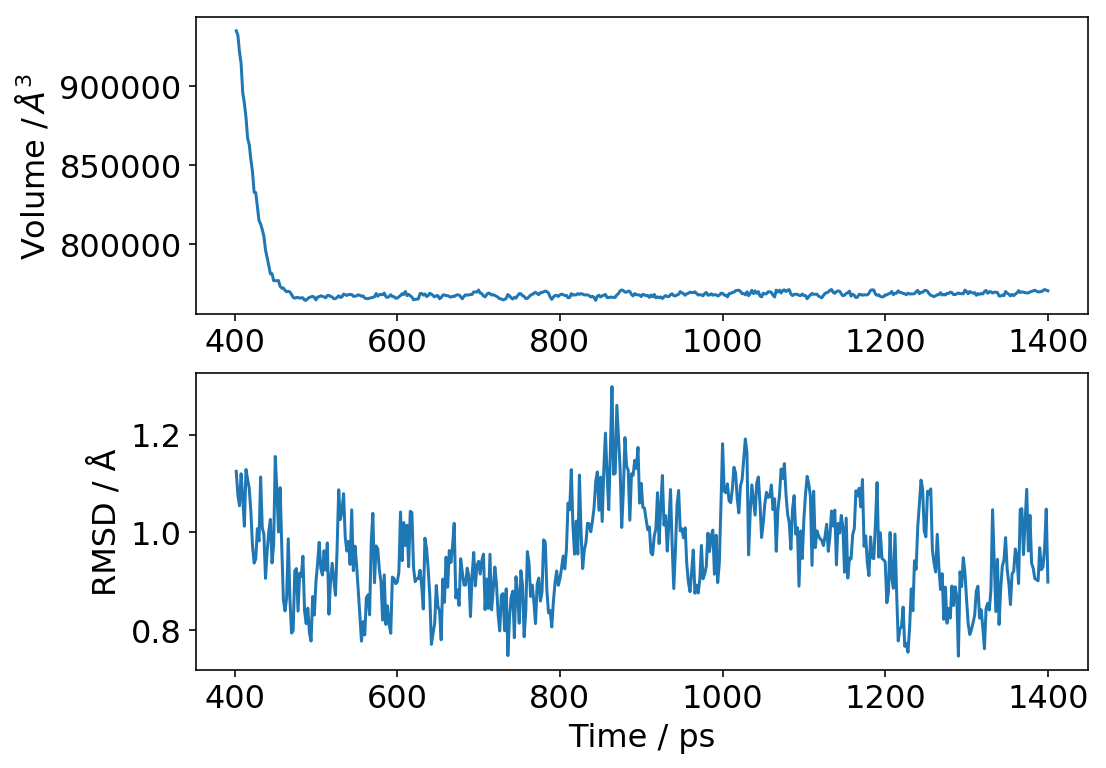

In [10]:
volu = []        # Volume in cubic angstrom.
time = []        # Time in picoseconds.
f = open("HEWL_POP.equil.mdout")
for line in f:
    fields = line.strip().split()
    if len(fields) > 6:
        if fields[3] == "TIME(PS)":
            time.append(fields[5])
        if fields[6] == "VOLUME":
            volu.append(fields[8])

if (do_simulation == False):
    traj = pt.load("HEWL_POP.equil.noWAT.nc", "HEWL_POP.equil.noWAT.parm7")
else: 
    traj = pt.load("HEWL_POP.equil.nc", "HEWL_POP.parm7")
ref_struc = pt.load("HEWL_POP.rst7", "HEWL_POP.parm7")
data_rmsd = pt.rmsd(traj, mask=['@CA'], ref=ref_struc)

plt.subplot(211) 
plt.plot(time[:-2], volu[:-2])        # Remove last two entries (not data points)
plt.ylabel("Volume /"+ r"$\/Å^{3} $")

plt.subplot(212)
plt.plot(time[:-2], data_rmsd)        # Remove last two entries from time only.
plt.xlabel("Time / ps")
plt.ylabel("RMSD / Å")

### Production
100 ns production run in *NPT* ensemble at 1 bar pressure using a Monte Carlo barostat, sampling from the isobaric-isothermal ensemble, and 300 K using Langevin dynamics.

In [11]:
%%bash -s "$do_simulation"
if [ "$1" = "True" ]; then

export CUDA_HOME=/usr/local/cuda
export AMBERHOME=/temp1/Software/amber16
source /temp1/Software/amber16/amber.sh

# Creating workdir
if [ ! -d "Production_POP" ]; then
  mkdir Production_POP
fi
cd Production_POP
cp ../HEWL_POP.parm7 .

cat <<EOF > production.mdin
Explicit solvent molecular dynamics
Production run
 &cntrl
   imin=0, irest=1, ntx=5,
   ntpr=1000, ntwx=25000, ntwr=25000, nstlim=50000000,
   dt=0.002, ntt=3, tempi=300,
   temp0=300, gamma_ln=1.0, ig=-1,
   ntp=1, ntc=2, ntf=2, cut=8,
   ntb=2, iwrap=1, ioutfm=1,
   barostat=2, pres0=1.0,
 /
EOF

pmemd.cuda -O -i production.mdin -p HEWL_POP.parm7 -c ../HEWL_POP.equil.rst7 -o HEWL_POP.prod.mdout -r HEWL_POP.prod.rst7 -x HEWL_POP.prod.nc
printf "Production run done!\n"

else
printf "Using pre-runned simulation.\nProduction run done!"
fi

Using pre-runned simulation.
Production run done!

## Post-production File Editing
Removal of water from the production run trajectory and topology. if `do_simulation = True` the trajectory containing explicit water (`HEWL_POP.prod.nc`) will be used for further analysis. The pre-runned simulation will however utilize the water striped trajectory (`HEWL_POP.prod.noWAT.nc`) and topology (`HEWL_POP.noWAT.parm7`), which can be found in the `Production_POP` directory. Additional the trajectory `HEWL_POP.prod.noWAT.nc` will be split into multiple smaller trajectories named using an integer with 0 being the first trajectory.

This post-production process is exclusively to generate smaller files and consequently having no effect on the further analysis (unless the coordinates of explicit water is required). The post-production file editing can be turned off by setting `do_post_edit = False` (see code below).

In [12]:
%cd -q $workdir_POP/Production_POP
do_post_edit = True
nested_int = 10     # number of trajectory files to be made.

if (do_simulation == True) and (do_post_edit == True):
    traj = pt.load('HEWL_POP.prod.nc', 'HEWL_POP.noWAT.parm7')
    traj_edit = pt.stip(traj, ':WAT')
    frames = list(range(0, traj_edit.n_frames))
    frame_list = []
    i = 0
    
    while (i < len(frames)):
        frame_list.append(frames[i:i+int(traj_edit.n_frames / nested_int)])
        i += int(traj_edit.n_frames / nested_int)
    
    for (i,j) in enumerate(frame_list):
        pt.write_traj('HEWL_POP.prod.noWAT_split.'+str(i)+'.nc', traj_edit, frame_indices=j)
    pt.write_parm('HEWL_POP.prod.noWAT.parm7', traj_edit.top)
    
    print("Post-production file editing done!")
elif (do_simulation == True) and (do_post_edit == False):
    print("Post-production file skiped!")
else:
    print("Using pre-runned simulation.\nPost-production file editing done!")

Using pre-runned simulation.
Post-production file editing done!


## Structual analysis
The structual analysis aims to provide preliminary insight into the dynamics of lysozyme in the pressence of pyrophosphate and the hence approximation of corase grain modelling of lysozyme a as rigid molecule equliviant to the native state in pure water. This will be investigated by 1) a root mean square deviation (RMSD) analysis to see the overall dynamics of lysozyme, 2) a principle component analysis (PCA) for the detection of correlated dynamics and discrete conformational states, and 3) a root mean square flucturation for the detection of dynamics regions within lysozyme.

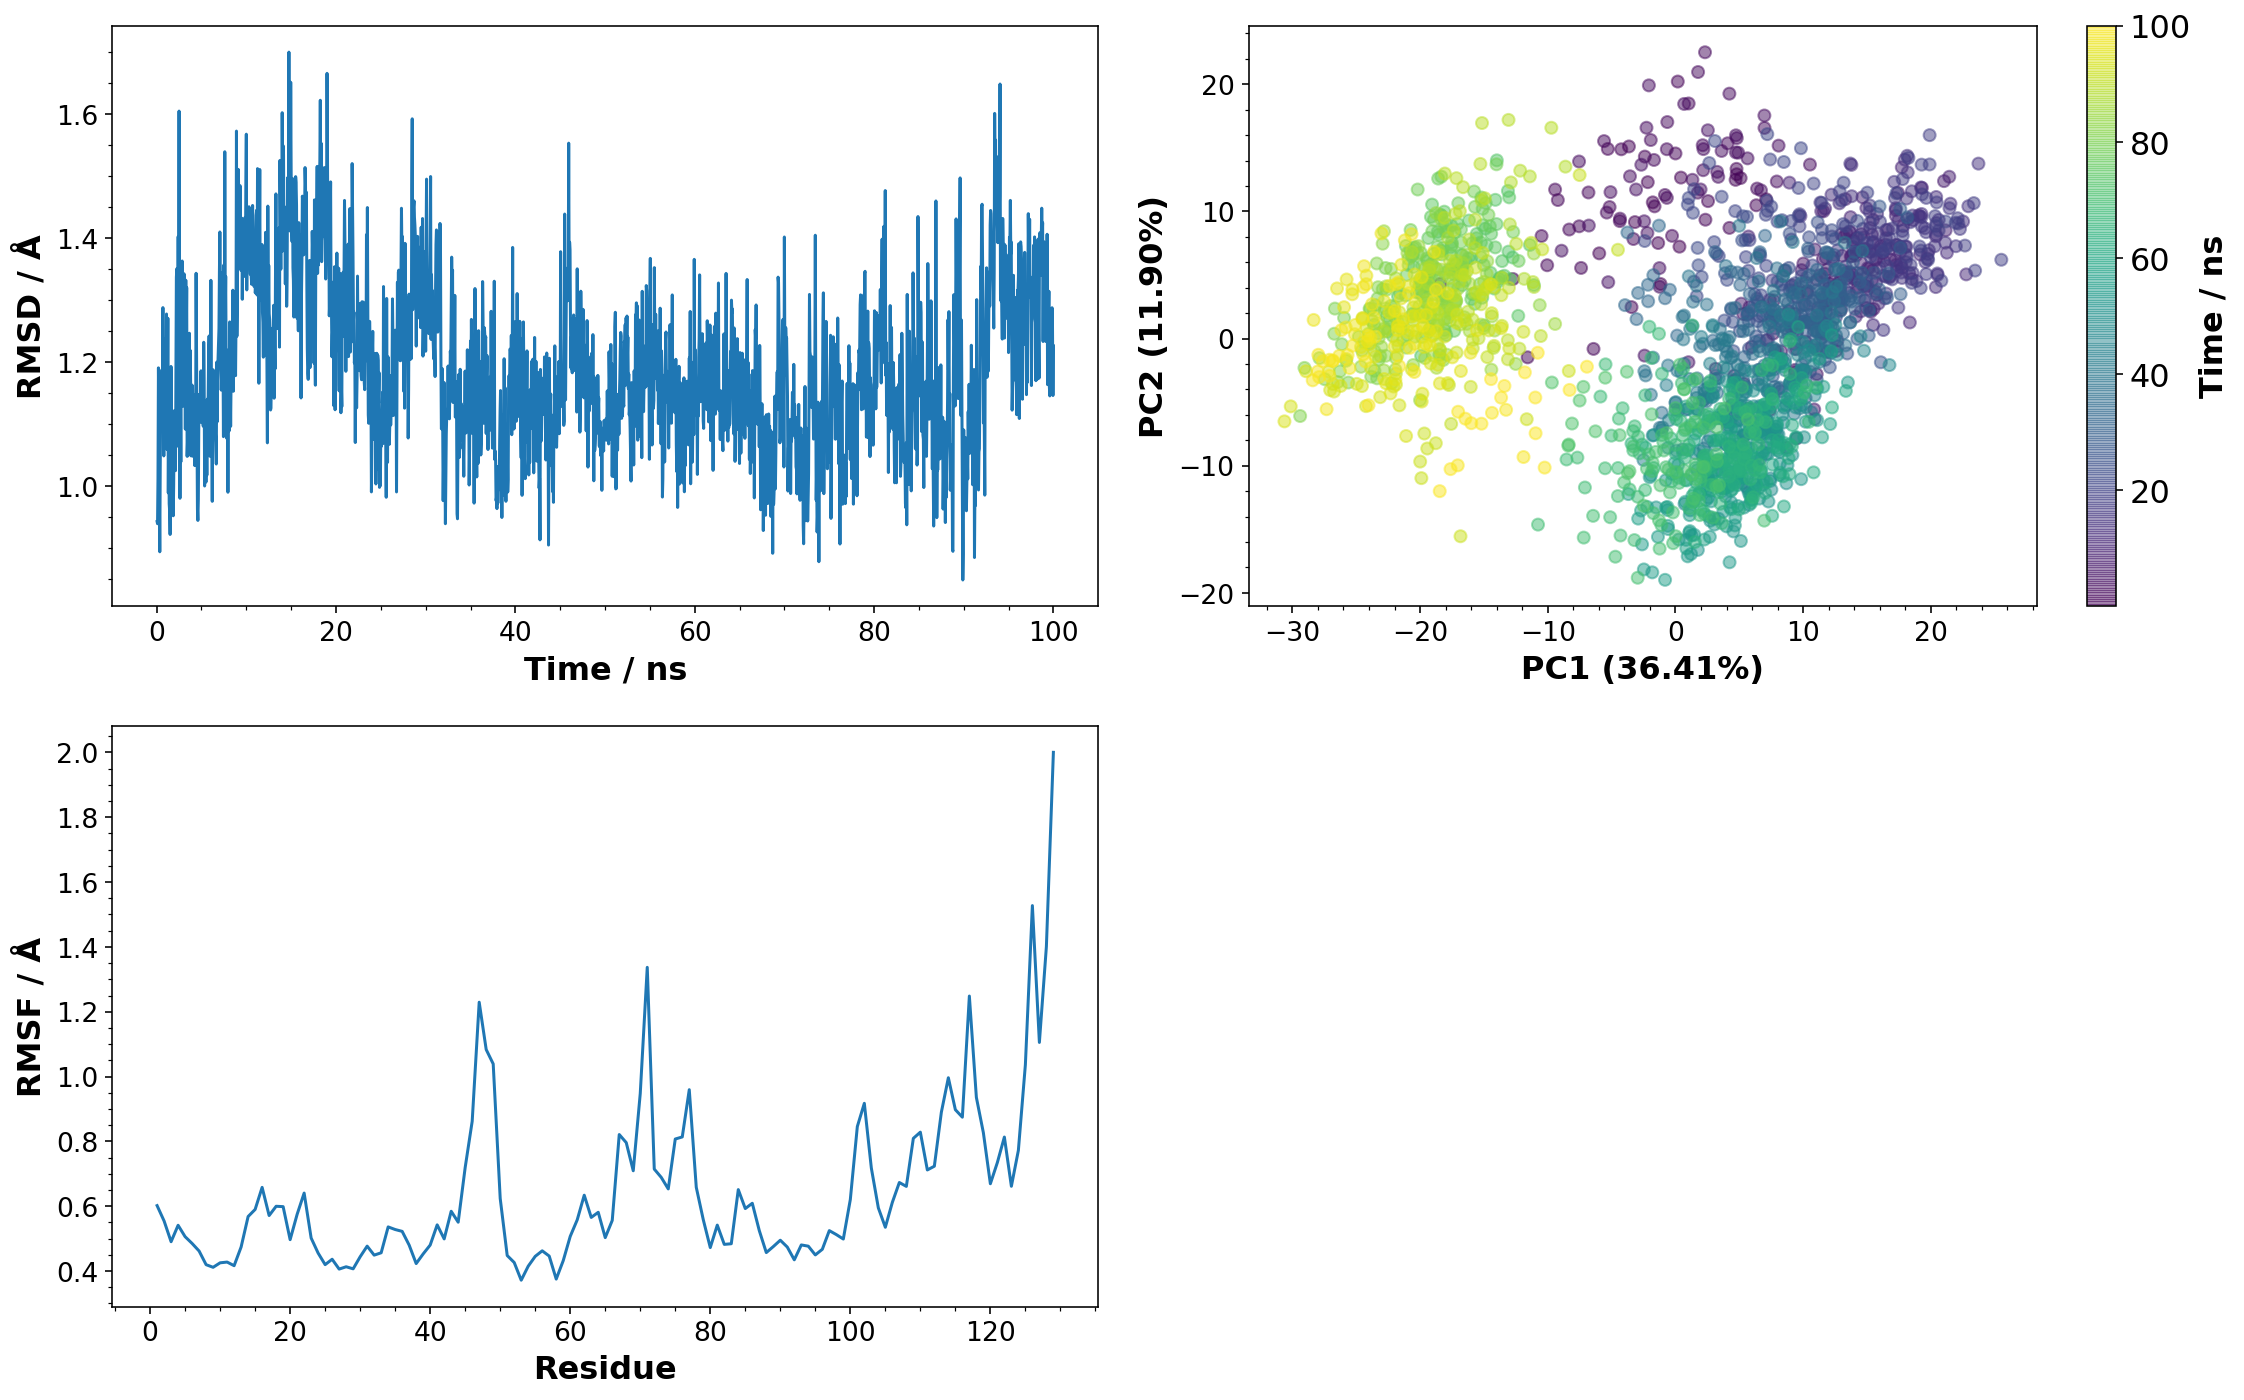

__**Figure 1**__: Structual analysis of lysozyme in the presence of pyrophopshate.
**Top-left**: Root mean square deviation (RMSD) analysis on heavy backbone atoms over the course of the simulation.
**Top-right**: Principle component analysis (PCA) on heavy backbone atoms for each frame in the trajectory.
**Bottom-left**: Root mean square flucturation (RMSF) analysis on heavy backbone atoms with all frames superimposed to the first frame in the simulation.

In [13]:
%cd -q $workdir_POP
plt.rcParams.update({'font.size': 16, 'figure.figsize': [16.0, 10.0]})    # Larger image

# Trajectories, topologies, and initial structure files
if (do_simulation == True):
    traj_POP = pt.load('Production_POP/HEWL_POP.prod.nc', 'Production_POP/HEWL_POP.parm7')
else:
    template = 'Production_POP/HEWL_POP.prod.noWAT_split.%s.nc'
    file_list = [template % str(i) for i in range(nested_int)]
    traj_POP = pt.iterload(file_list, 'Production_POP/HEWL_POP.prod.noWAT.parm7')
    traj.save('Production_POP/HEWL_POP.prod_v2.nc', overwrite=True)
ref_POP = pt.load('HEWL_POP.rst7', 'HEWL_POP.parm7')

# Steps and time (ns)
steps = list(range(0, traj_POP.n_frames))
time = [i * 0.05 + 0.05 for i in steps]

# Root mean square deviation (RMSD) on heavy backbone atoms /w initial structure as reference
rmsd_POP = pt.rmsd(traj_POP, mask=['@CA,C,O,N&!(:WAT|:POP)'], ref=ref_POP)

# Principal component analysis
pca_POP = pt.pca(traj_POP, mask='@CA,C,O,N&!(:WAT|:POP)', n_vecs=-1)
PC1_POP_var = pca_POP[1][0][0] / sum(pca_POP[1][0])
PC2_POP_var = pca_POP[1][0][1] / sum(pca_POP[1][0])
projection_POP = pca_POP[0]

# Root mean square fluctuation (RMSF) on CA, with all frames superimposed to first frame.
if (do_simulation == True):
    rmsf_traj = pt.superpose(traj_POP, ref=0, ref_mask='@CA,C,O,N&!(:WAT|:POP)')
    rmsf_data = pt.atomicfluct(rmsf_traj, mask='@CA,C,O,N&!(:WAT|:POP)', options='byres')
else:
    traj_POP_v2 = pt.load('Production_POP/HEWL_POP.prod_v2.nc', 'Production_POP/HEWL_POP.prod.noWAT.parm7') # Requirement for RMSF and animation
    os.remove('Production_POP/HEWL_POP.prod_v2.nc') # Remove non-required file.
    rmsf_traj = pt.superpose(traj_POP_v2, ref=0, ref_mask='@CA,C,O,N&!(:WAT|:POP)')
    rmsf_data = pt.atomicfluct(rmsf_traj, mask='@CA,C,O,N&!(:WAT|:POP)', options='byres')

# Plotting:
plt.subplot(221)
plt.plot(time, rmsd_POP)
plt.xticks(size='small')
plt.yticks(size='small')
plt.xlabel('Time / ns', weight='bold')
plt.ylabel('RMSD / Å', weight='bold')
plt.minorticks_on()

plt.subplot(222)
plt.scatter(projection_POP[0], projection_POP[1], marker='o', c=time, alpha=0.5)
plt.xlabel('PC1 ({:.2f}%)'.format(PC1_POP_var*100), weight='bold')
plt.ylabel('PC2 ({:.2f}%)'.format(PC2_POP_var*100), weight='bold')
plt.xticks(size='small')
plt.yticks(size='small')
plt.minorticks_on()
cbar = plt.colorbar()
cbar.set_label('Time / ns', weight='bold')

plt.subplot(223)
plt.plot(rmsf_data.T[0], rmsf_data.T[1])
plt.xticks(size='small')
plt.yticks(size='small')
plt.xlabel('Residue', weight='bold')
plt.ylabel('RMSF / Å', weight='bold')
plt.minorticks_on()

plt.tight_layout()
plt.show()
Markdown('''__**Figure 1**__: Structual analysis of lysozyme in the presence of pyrophopshate.
**Top-left**: Root mean square deviation (RMSD) analysis on heavy backbone atoms over the course of the simulation.
**Top-right**: Principle component analysis (PCA) on heavy backbone atoms for each frame in the trajectory.
**Bottom-left**: Root mean square flucturation (RMSF) analysis on heavy backbone atoms with all frames superimposed to the first frame in the simulation.''')

### Trajectory visualization

In [14]:
trajview_POP = pt.autoimage(traj_POP_v2)
view = nv.show_pytraj(trajview_POP)
view

NGLWidget(count=500)

In [15]:
view.clear()
view.add_representation('cartoon', selection='protein', color='residueindex')
view.add_ball_and_stick('not protein', opacity=0.15)
view.render_image()
Markdown('''__**Figure 2**__: Animation of the trajectory simulated with the protein backbone represented
            by cartoon ribbons, while chloride, sodium and pyrophosphate ions are represented as balls and sticks.''')

__**Figure 2**__: Animation of the trajectory simulated with the protein backbone represented
            by cartoon ribbons, while chloride, sodium and pyrophosphate ions are represented as balls and sticks.

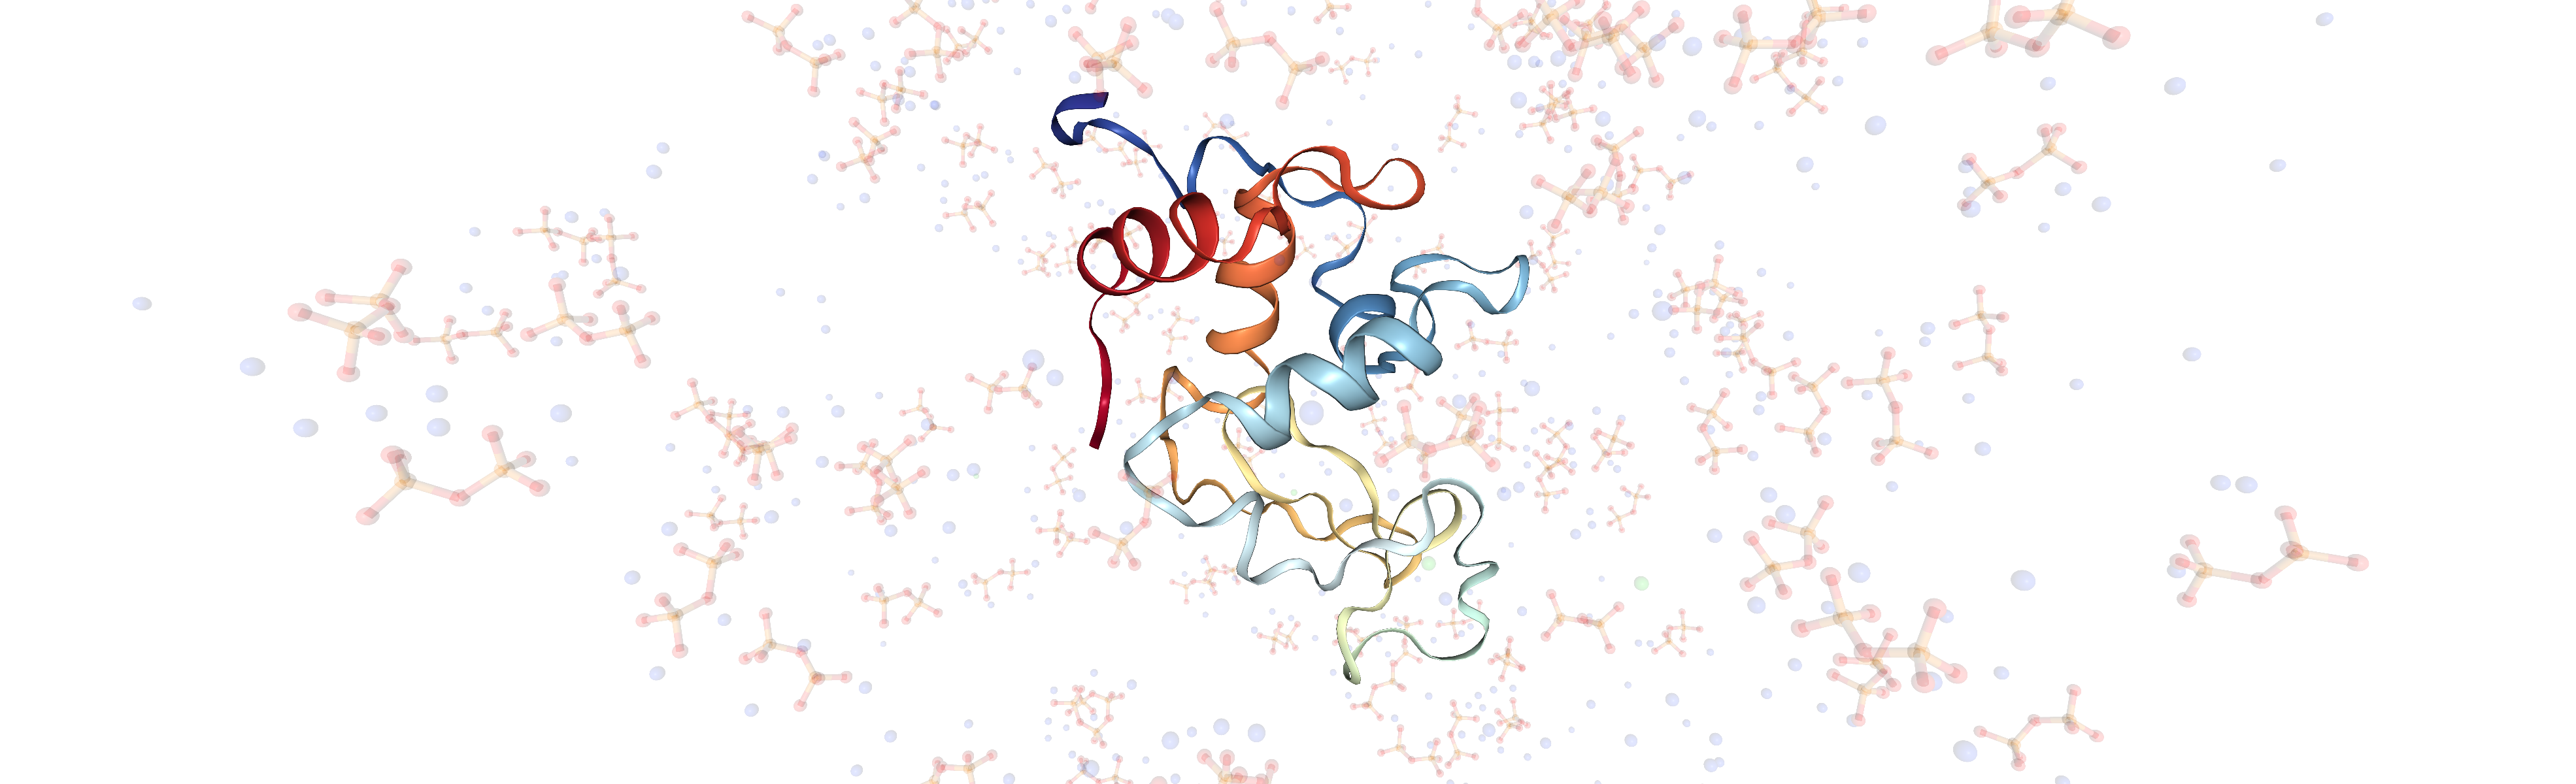

In [17]:
view._display_image()  # Cell may have to be run twice.

## Appendix
### Inclusion of electronic polarizability of water
Non-polarizable force fields usually account for electrostatics through the Coulomb law with a dielectric constant of 1 for water, thus the expression below
$$ E_{el}=\frac{q_{i}q_{j}}{\epsilon_{0}r} $$
However the neglect of polarizability has also shown to introduce errors when compared to structual experiments. Consequently it is desirable to utilize polarizable force fields. The new-generation polarizable force fields are however commonly to costly to be used for molecular dynamics on longer timescales. Assuming the polarizability of salt and solute is neglectable, the electronic polarizability of water can be included in a simple but effective way, by scaling all ionic charges by $\frac{1}{\sqrt{\epsilon_{el}}}$, as it can be obtained from the expression below
$$E_{el}=\frac{q_i \frac{1}{\sqrt{\epsilon_{el}}} ~ q_j \frac{1}{\sqrt{\epsilon_{el}}}}{\epsilon_{0}r}=
\frac{q_{i}q_{j} \left( \frac{1}{\sqrt{\epsilon_{el}}} \right)^{2} }{\epsilon_{0}r}=
\frac{q_{i}q_{j}}{\epsilon_{0} \epsilon_{el} r}$$